In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library.ODE_library import fun_bogdanov_takens
import matplotlib.pyplot as plt

import sys
from MARBLE import utils, geometry, net, plotting

rng = np.random.RandomState(1)

Bogdanov-Takens system http://www.scholarpedia.org/article/Bogdanov-Takens_bifurcation

# Display state spaces under four different parameter conditions

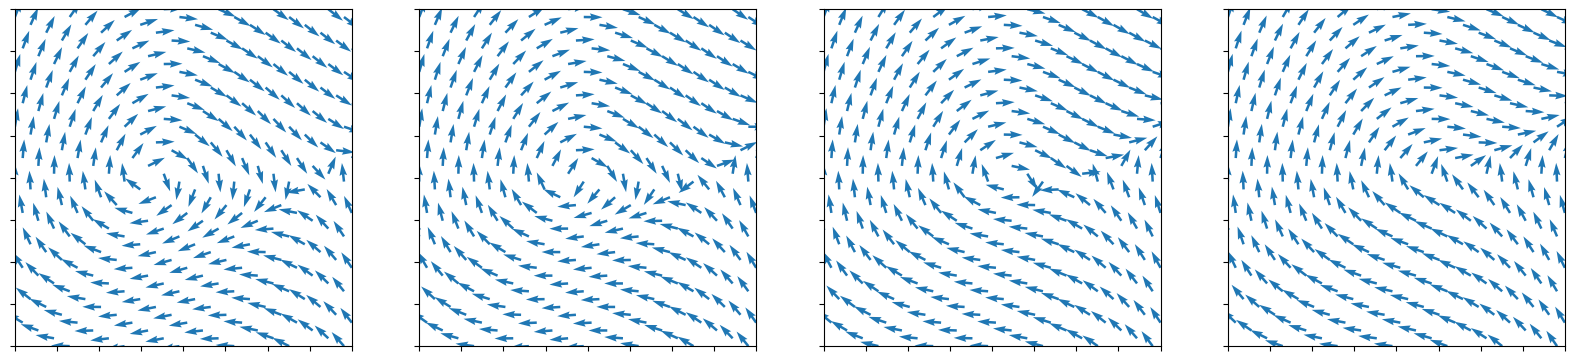

In [2]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

def simulate_system(beta1):
    n = 2000
    pos = geometry.sample_2d(n, [[-1,-1],[1,1]], 'uniform')
    f, _ = fun_bogdanov_takens(par = {'beta1': beta1, 'beta2': -0.6})
    vel = np.vstack([f(0, p) for p in pos])
    return pos, vel

def plot_phase_portrait(pos, vel, ax, style='>', arrow_spacing=7):

    ax = plotting.trajectories(pos, vel, ax=ax, style=style, lw=1, arrowhead=.03, arrow_spacing=arrow_spacing, axis=False, alpha=None)
    ax.axis('square')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    
pos, vel = simulate_system(-0.15)
plot_phase_portrait(pos, vel, ax[0])
pos, vel = simulate_system(-0.05)
plot_phase_portrait(pos, vel, ax[1])
pos, vel = simulate_system(0.05)
plot_phase_portrait(pos, vel, ax[2])
pos, vel = simulate_system(0.15)
plot_phase_portrait(pos, vel, ax[3])

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [3]:
beta1 = np.linspace(-.15,.15,10)

pos, vel = [], []
for b1 in beta1:
    p, v = simulate_system(b1)
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))

# Train network

In [4]:
k=10

ind = rng.permutation(len(beta1))
pos_subsample = [pos[i] for i in ind]
vel_subsample = [vel[i] for i in ind]

data = utils.construct_dataset(pos_subsample, features=vel_subsample, graph_type='cknn', k=k)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size, this should be as large as possible
       'epochs': 30, #optimisation epochs
       'order': 2, #order of derivatives
       'depth': 0, #number of hops in neighbourhood
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 4,
       'diffusion': False,
       'inner_product_features': False
      }

model = net(data, **par)
model.run_training(data)

Computing gauges...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


---- Settings: 

batch_size : 256
epochs : 30
order : 2
depth : 0
n_lin_layers : 2
hidden_channels : 16
out_channels : 4
diffusion : False
inner_product_features : False
vector : False
frac_geodesic_nb : 2.0
var_explained : 0.9
frac_sampled_nb : 0.8
dropout : 0.0
bias : False
batch_norm : batch_norm
lr : 0.01
seed : 0
signal_dim : 2
emb_dim : 2
n_sampled_nb : 8
n_geodesic_nb : 20
dim_signal : 2
dim_man : tensor(2)


---- Number of features to pass to the MLP:  14
---- Total number of parameters:  377
---- Embedding dimension: 2
---- Manifold dimension: 2

 Signal dimension = manifold dimension, so manifold computations are disabled!

---- Starting training ... 

Epoch: 1, Training loss: 67.8510, Validation loss: 68.2922
Epoch: 2, Training loss: 63.9349, Validation loss: 67.4092
Epoch: 3, Training loss: 63.1535, Validation loss: 64.2008
Epoch: 4, Training loss: 62.2994, Validation loss: 64.6037
Epoch: 5, Training loss: 61.3110, Validation loss: 63.3831
Epoch: 6, Training loss: 60.1872, 

# Create embeddings and cluster

In [ ]:
n_clusters = 30
data = model.evaluate(data)

# Visualise embedding

In [ ]:
tsne_emb, clusters, dist = geometry.cluster_embedding(data, n_clusters=n_clusters)
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1[ind]]
plotting.embedding(tsne_emb, data.y.numpy(), clusters, titles=titles)#, save='scalar_fields_embedding.svg') 

In [ ]:
#dist = geometry.compute_distribution_distances(data)
emb_MDS = geometry.embed(dist, embed_typ='MDS')
plotting.embedding(emb_MDS, beta1[ind])

In [ ]:
#plotting.neighbourhoods(data, clusters, hops=1)